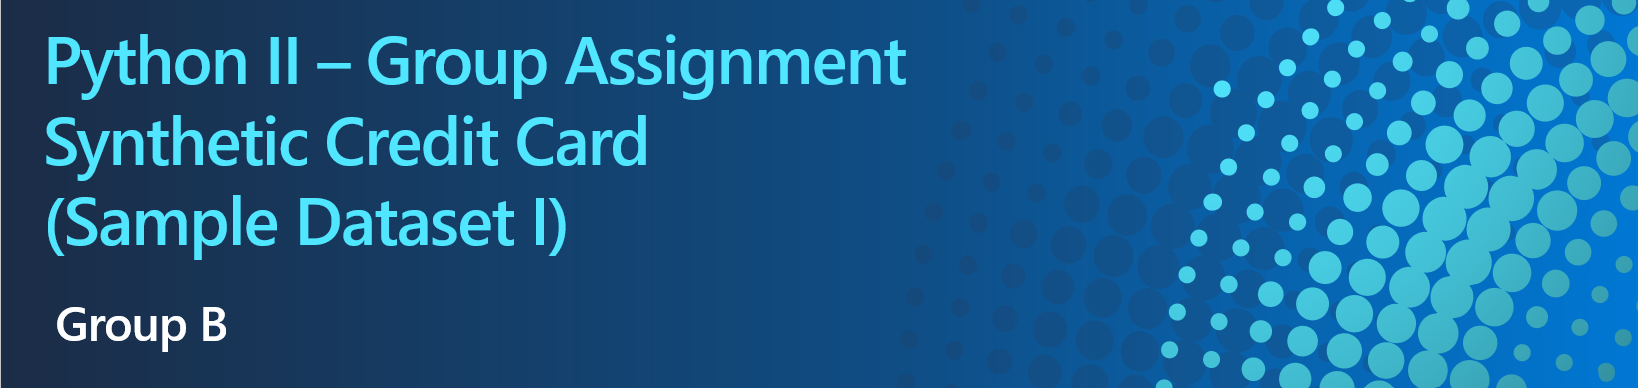

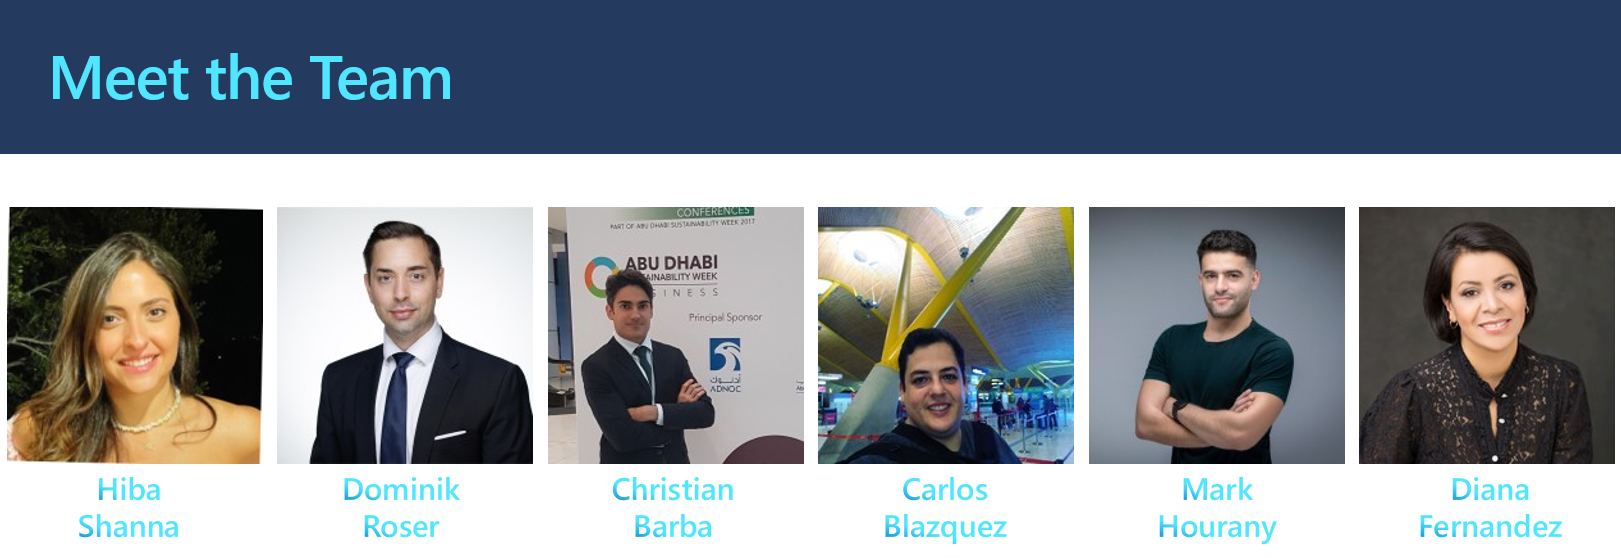


# An approach to detecting and understanding Machine Learning Biases using classes

# Table of Contents

**[1. The Syntetic Credit Card Data Set](#heading--1)**

**[2. FairDetect Framework](#heading--2)**

  * [2.1. Importing Relevant Libraries](#heading--2-1)
  * [2.2. Loading Dataset](#heading--2-2)
  * [2.3. Data Exploration](#heading--2-3)
  * [2.4. Training the Machine Learning Model](#heading--2-4)
  * [2.5. Bias Detection](#heading--2-5)  
  * [2.6. Model Importance Comparison](#heading--2-6)
  * [2.7. Disparete Impact](#heading--2-7)   
  * [2.8. Saving to SLQ Lite 3](#heading--2-8)   
  
**[3. Aequitas Framework](#heading--3)**
  
  * [3.1. Importing elevant Libraries](#heading--3-1)
  * [3.2. Loading and Reformating Datase to fit Aequitas framework ](#heading--3-2)
  * [3.3. Model Biases](#heading--3-3)
  * [3.4. Model Disparities](#heading--3-4)  
  * [3.5. Overal Fairness](#heading--3-5)
  * [3.6. Parity Test](#heading--3-6)    

  

<a id='heading--1'></a>
# 1. The Syntetic Credit Card DataSet

The dataset contains, for each applicant:

- Income (in the Income column),
- The number of children (in the Num_Children column),
- Whether the applicant owns a car (in the Own_Car column, the value is 1 if the applicant owns a car, and is else 0), and
- Whether the applicant owns a home (in the Own_Housing column, the value is 1 if the applicant owns a home, and is else 0)
- When evaluating fairness, we'll check how the model performs for users in different groups, as identified by the Group column:

The Group column breaks the users into two groups (where each group corresponds to either 0 or 1).

For instance, you can think of the column as breaking the users into two different races, ethnicities, or gender groupings. If the column breaks users into different ethnicities, 0 could correspond to a Hispanic user, while 1 corresponds to a non-Hispanic user.

<a id='heading--2'></a>
# 2. FairDetect Framework

Congregating the various theoretical concepts into a practical framework, we can follow the “theoretical lens of a ‘sense-plan-act’ cycle”, as described by the HLEG framework (European Commission and Directorate-General for Communications Networks, Content and Technology, 2019). Applying this concept to the problem of ML fairness, we can break down three core steps in providing robust, and responsible artificial intelligence: Identify, Understand, and Act (IUA).

1. __Identify__: The process of exposing direct or indirect biases within a dataset and/or model.
1. __Understand__: The process of isolating impactful scenarios and obtaining trans parent explanations for outcomes.
1. __Act__: The process of reporting and rectifying identified disparities within the

By understanding the philosophical forms of unfairness as defined by our review of the literature and categorizing our prominent fairness metrics into the overarching categories of representation, ability, and performance, we can establish a series of tests to “identify” levels of disparities between sensitive groups at different levels. Merging these findings with the explainability of our models through the use of white-box models, or Shapley value estimation for black-box models, we can dig deeper into the model’s predictions, “understanding” how classifications were made, and how they varied from the natural dataset exposing both natural biases as well as added model differences. Finally, by probing further into levels of misclassification, in particular looking at negative outcomes, we can isolate groups most at risk and set up a series of “actions” that can be taken to mitigate the effects. Given this three-step framework which combines societal, legal, and technical considerations, the paper will then go through a series of cases, and examine the proposed framework.

<a id='heading--2-1'></a>
## 2.1 Importing Relevant Libraries

In [1]:
### pip install fairdetect-groupb==0.47

In [2]:
# Importing our Libraries
from __future__ import print_function
import sqlite3
import pandas as pd 
import fairdetect_groupb


time taken in execution is : 1.0779814720153809


In [3]:
fd=fairdetect_groupb.Fairdetect(None,None,None)

<a id='heading--2-2'></a>
## 2.2 Loading Dataset

In [4]:
# Loading our DataFrame
data = pd.read_csv('synthetic_credit_card_approval.csv')
data

Num_Children  Group  Income  Own_Car  Own_Housing  Target
0                  4      0   36151        0            0       0
1                  0      0   36095        1            0       0
2                  2      1   62110        1            1       0
3                  0      1   73644        1            0       0
4                  3      0   99146        0            0       1
...              ...    ...     ...      ...          ...     ...
499995             1      0   43299        1            1       0
499996             8      1   75956        1            1       1
499997             3      0   66476        0            0       0
499998             2      1   74524        0            0       0
499999             4      0   31129        1            0       0

[500000 rows x 6 columns]

In [5]:
data_ae = data.copy()

In [6]:
data_bd = data.copy()

<a id='heading--2-3'></a>
## 2.3 Data Exploration
 

In [7]:
#!pip install pandas-profiling
# uncomment this cell to install it

In [8]:
from pandas_profiling import ProfileReport
report = ProfileReport(data_bd, minimal=False)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<a id='heading--2-4'></a>
## 2.4 Training the Machine Learning Model

### Target Variable Definition

In [9]:

target = fd.check_for_target(data_bd)
# INSERT: Target

['Num_Children' 'Group' 'Income' 'Own_Car' 'Own_Housing' 'Target']
Please select target columnTarget
You choose wisely. Your target variable is: Target


### Splitting the data into train and test

In [10]:
from sklearn.model_selection import train_test_split
X = data_bd.drop([target],axis=1) # axis: {0 or ‘index’, 1 or ‘columns’}, default 0
y = data_bd[target]

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=0)
print("Data sucessfully loaded!")

Data sucessfully loaded!


### Model Training

In [11]:
#pip install xgboost

In [12]:
import xgboost
model = xgboost.XGBClassifier().fit(X_train, y_train)
y_test_predict = model.predict(X_test)
y_test_predict

array([1, 0, 0, ..., 0, 0, 1])

### Creating the Object

In [13]:
bd=fairdetect_groupb.Fairdetect(model,X_test,y_test)

<a id='heading--2-5'></a>
## 2.5 Bias Detection



### Representation of Sensitive Variables

In [14]:
sensitive=bd.get_sensitive_col()
labels=bd.create_labels(sensitive)
bd.identify_bias(sensitive,labels)


#INSERT the column name of the Sensitive Variable: Group
#INSERT label 0: hispanic
#INSERT in label 1: non_hispanic

#Target Variable
#INSERT label 0: Denied
#INSERT in label 1: Approved


Please select the sensitive column name from given features
['Num_Children' 'Group' 'Income' 'Own_Car' 'Own_Housing']
Enter sensitive column here : Group

Please Enter Label for Group 0: hispanic
Please Enter Label for Group 1: non-hispanic

Enter Target names below
Please Enter name for target predicted 0: denied
Please Enter name for target predicted 1: approved
REPRESENTATION


╒══════════╤════════════╤════════════════╕
│          │   hispanic │   non-hispanic │
╞══════════╪════════════╪════════════════╡
│ denied   │   0.804943 │       0.423006 │
├──────────┼────────────┼────────────────┤
│ approved │   0.195057 │       0.576994 │
╘══════════╧════════════╧════════════════╛ 

*** Reject H0: Significant Relation Between Group and Target with p= 0.0


ABILITY


Accept H0: True Positive Disparity Not Detected. p= 0.7159221552842456
Accept H0: False Positive Disparity Not Detected. p= 0.588169391004731
Accept H0: True Negative Disparity Not Detected. p= 0.9319949919140254
Accept H0: False Negative Disparity Not Detected. p= 0.1040665041132579


PREDICTIVE


Accept H0: No Significant Predictive Disparity. p= 0.700437584401918


In [15]:
print(labels)

{0: 'hispanic', 1: 'non-hispanic'}


**SUMMARYZING OUTCOME AND RESULTS:**

While the dataset has a balanced representation of each of the sensitive groups (50% each), the target variable, the credit allocation, shows a 61-39% distribution.
As it can be seen in the contingency table, the breakdown of each of the groups does not follow the initial distribution, with the following outcomes:
- only 20% of the hispanics in the sample have received a credit card 
- compared to 58% of approved credit card for non-hispanics

This clear unabalance triggers the chi square test (rejects null hypotheis) confirming there seems to be a singificant relation between the group and the outcome. 

In the Ability module which analyzes the confusion matrix: 
- the groups seems balanced in the TPR 93% for Hispanic vs 98% for non-Hispanic.
- In relation to the TNR, the model behaves pretty similarly for both categories: 98 vs 97%.
- FPR have a result of slightly below 2% FPR for Hispanics and a 3% for non-Hispanic. 
- the FNR is the less balanced of the 4 metrics with a 7% for Hispanic and a 2% for non-hispanic

The conclusion of the chi square test on the equalized odds is that there is no disparity in the ability of the classes as shown by the acceptance of the null hypothesis in the 4 cases (TPR,TNR,FPR,FNR).  

Finally, in the predictive section, the precision scores obtained for each group are 92.4% for Hispanics and 97.7 for non-Hispanics. The Chi square test indicates there is no significant disparity in the results of the prediction as compared to the distribution of the data set.  

<a id='heading--2-6'></a>
## 2.6 Model Importance Comparison

Visualization for affected_group = 0 and affected_target = 0


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Model Importance Comparison


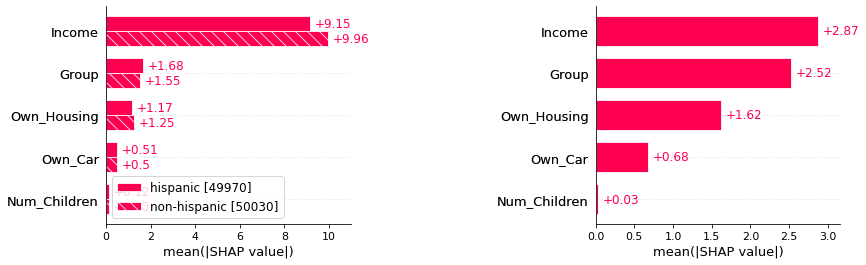

Affected Attribute Comparison
Average Comparison to True Class Members


Average Comparison to All Members


Random Affected Decision Process
Visualization for affected_group = 0 and affected_target = 1
Model Importance Comparison


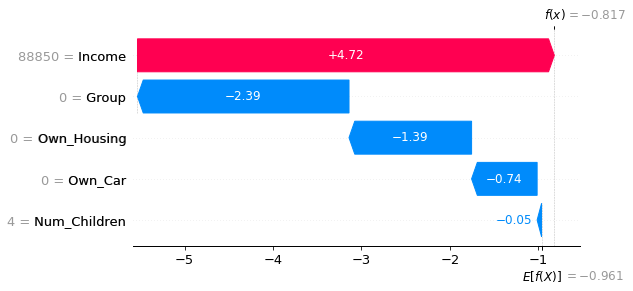

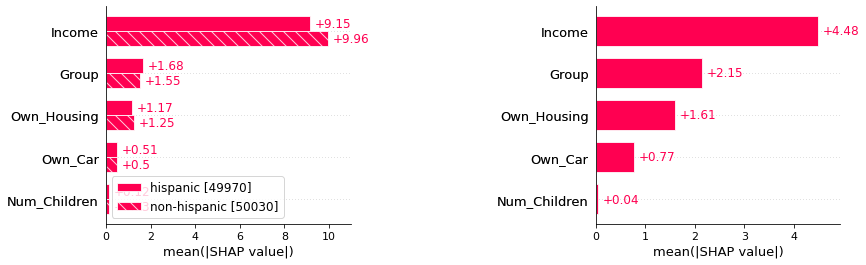

Affected Attribute Comparison
Average Comparison to True Class Members


Average Comparison to All Members


Random Affected Decision Process
Visualization for affected_group = 1 and affected_target = 0
Model Importance Comparison


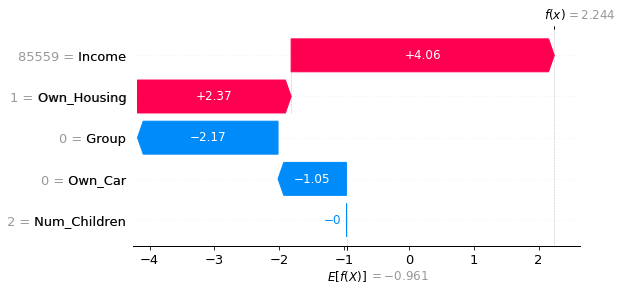

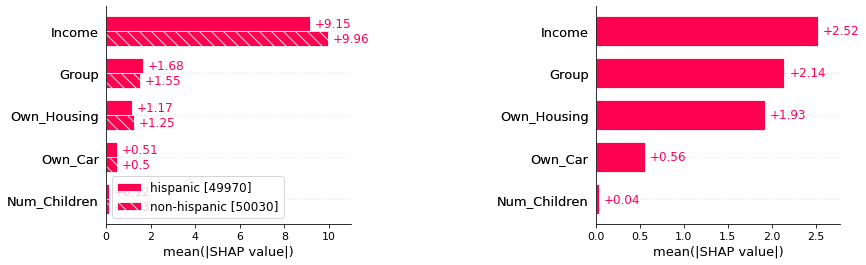

Affected Attribute Comparison
Average Comparison to True Class Members


Average Comparison to All Members


Random Affected Decision Process
Visualization for affected_group = 1 and affected_target = 1
Model Importance Comparison


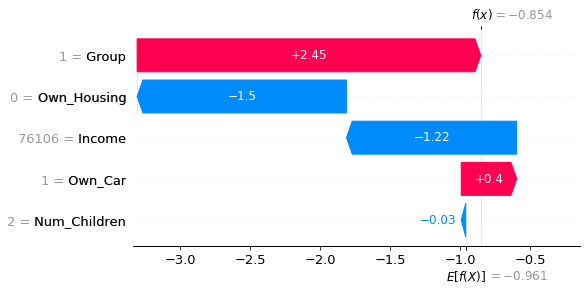

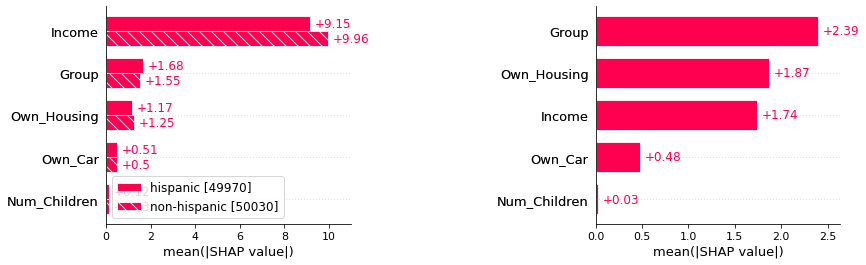

Affected Attribute Comparison
Average Comparison to True Class Members


Average Comparison to All Members


Random Affected Decision Process


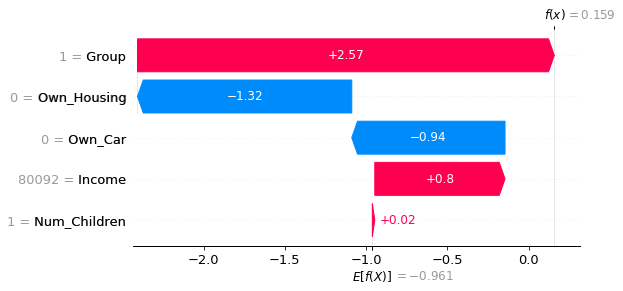

In [16]:

from itertools import product

for i,j in product([0,1],repeat=2):
  print("Visualization for affected_group = {0} and affected_target = {1}".format(i,j))
  bd.understand_shap(labels,sensitive,i,j)

**SUMMARYZING OUTCOME AND RESULTS:**

Despite the first analysis has not detected significant bias in the results, we are going to deepdive for group 0 (hispanic) that have miscorrectly been rejected the credit card (placed in target 0 instead of in target 1)

Overall we see the model gives slightly more importance to income for Hispanics as opposed to non-hispanics while the other parameters have roughly the same impact. 

Focusing now on the non-Hispanic group wrongly classified in group 0, we can see that all parameters have the same relative importance however income has a really smaller contribution or in other words, has been undervalued for the positive outcome. 

This can be noticed also in the comparison with the true positives class, where we see that false negatives tend to have a much bigger income than true positive of 22.4%.

Comparing the non-hispanic false negatives with all the group, the caracteristic that appears as more differential is that they tend to own a house.    

Looking at a specific individual, we see that not owning a house and a car have impacted more on the classification on group 0 instead of group 1, while being non-hispanic has had a positive impact that has not been able to compensate the previously indicated factors.    



In [17]:
#Storing the most recent p-value out of the True Positive Disparity Rate, the False Positive Disparity Rate, the True Negative Rate and the False Negative Disparity Rate in variables
p_TPR = bd.TPR_p
p_FPR = bd.FPR_p
p_TNR = bd.TNR_p
p_FNR = bd.FNR_p

<a id='heading--2-7'></a>
## 2.7 Disparate impact 

The disparate impact is a metric to evalute the fairness. 
It differentiates between an unpriviliged/unfavoured group and a priviliged/favoured group. 
In the calculation is the proporition of the unpriviliged/unfavoured group that receives the positive outcome of the event, 
divided by the proporiton of priviliged group that receiveds the positive outcome. 

The results is interpreted by the four-fifths rule: if the unprivileged group has a less positive outcome than 80% compared
to the priviliged group there a diparate impact violation. 

In this analysis we also defined that a ratio of 80-90% is a sign of mild impact violation. A ratio of 1 is an indication for perfect equality. 



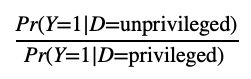

Disparate Impact, Sensitive vs. Predicted Target: 2.958077395278232
The disparate impact ratio indicated complete equality between the favoured and unfavoured group


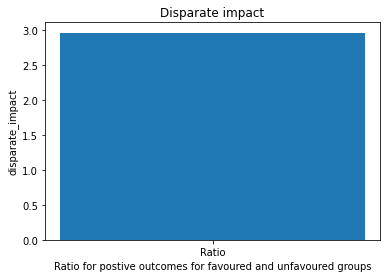

In [18]:
disparate_impact=bd.disparate_impact(sensitive,labels)

<a id='heading--2-8'></a>
## 2.8 Saving to SQL lite3 

In case we want to calculate further with the KPIs of the fairdetect method at a later stage and do not want to call of the fuctions above, we could store the intermediate results in SQLite.

In [19]:
#First important relevant methods to run sql alchemy
import sqlalchemy as db
from sqlalchemy import create_engine
from sqlalchemy import inspect
from sqlalchemy import Column, Integer, DateTime
import datetime

class store_pvalues:
    
    def __init__(self,p_TPR,p_FPR,p_TNR,p_FNR,disparate_impact):
        self.p_TRP,self.p_FPR,self.p_TNR,self.p_FNR,self.disparate_impact = p_TPR,p_FPR,p_TNR,p_FNR,disparate_impact

    
    def dynamic_data_entry(self,p_TPR,p_FPR,p_TNR,p_FNR,disparate_impact):
        """
        Method to insert pvalues of TPR, FRP, TNR and FNR in dynamic way into a table
        
        
        Parameter
        -------   
        p_TPR: p value of True Positive Rate calculation
        p_FPR: p value of False Positive Rate calculation
        p_TNR: p value of True Negative Rate calculation 
        p_FNR: p value of False Negative Rate calculation 
        disparate_impact: value of disparate_impact calculation
        """
        query = db.insert(pvalues).values(Id=123, p_TPR = self.p_TRP, p_FPR = self.p_FPR, p_TNR = self.p_TNR, p_FNR = self.p_FNR, disparate_impact = self.disparate_impact) 
        ResultProxy = connection.execute(query)

We first create the database credict card approval for all tables related to the dataset. Then we connect to the database and create the table pvalues that should store the pvalues of TPR, TNR, FPR and FNR. 

In [20]:
engine = db.create_engine('sqlite:///credit_card_approval.db') #Create credit_card approval.sqlite automatically
connection = engine.connect() #connect database
metadata = db.MetaData()

pvalues = db.Table('pvalues', metadata,
              db.Column('Id', db.Integer()),
              db.Column('date', db.types.DateTime(timezone=True), default=datetime.datetime.utcnow),
              db.Column('p_TPR', db.Float(), default=100.0),
              db.Column('p_FPR', db.Float(), default=100.0),
              db.Column('p_TNR', db.Float(), default=100.0),
              db.Column('p_FNR', db.Float(), default=100.0),
              db.Column('disparate_impact', db.Float(), default=100.0)
              )

metadata.create_all(engine) #Command to create the table

Through the inspector method it is possible to check which tables are in the respective database and which columns the tables have

In [21]:
inspector = inspect(engine)
connection = engine.connect()
#printing the name of the table to check if it was successfully created
print(inspector.get_table_names())

['pvalues']


In [22]:
#printing the columns 
print(pvalues.columns.keys())

['Id', 'date', 'p_TPR', 'p_FPR', 'p_TNR', 'p_FNR', 'disparate_impact']


Furthermore we can also look at the metadata of the table and see what type of columns it has. 

In [23]:
#showing the metadata of the sql alchemy table
print(repr(metadata.tables['pvalues']))

Table('pvalues', MetaData(), Column('Id', Integer(), table=<pvalues>), Column('date', DateTime(timezone=True), table=<pvalues>, default=ColumnDefault(<function datetime.utcnow at 0x0000022B4C785E50>)), Column('p_TPR', Float(), table=<pvalues>, default=ColumnDefault(100.0)), Column('p_FPR', Float(), table=<pvalues>, default=ColumnDefault(100.0)), Column('p_TNR', Float(), table=<pvalues>, default=ColumnDefault(100.0)), Column('p_FNR', Float(), table=<pvalues>, default=ColumnDefault(100.0)), Column('disparate_impact', Float(), table=<pvalues>, default=ColumnDefault(100.0)), schema=None)


After the table was successfully created, we follow the same methodology as in fairdetect to first create the object of data entry and then enter the dynamic data itself. 

In [24]:
p_value_object = store_pvalues(p_TPR,p_FPR,p_TNR,p_FNR,disparate_impact)

We then call the object with the respective method of data entry and hand over the most recent p-values of TRP, FPR, TNR, FNR that resulted from the fairdetect analysis

In [25]:
insert_data = p_value_object.dynamic_data_entry(p_TPR,p_FPR,p_TNR,p_FNR,disparate_impact)

In order to check if the data was inserted we check for the most recent data entries in the database of credict card approval and print the latest five results

In [26]:
query = db.select([pvalues]) 
ResultProxy = connection.execute(query)
ResultSet = ResultProxy.fetchall()
ResultSet[:5]

[(123, datetime.datetime(2022, 7, 31, 8, 30, 36, 238511), 0.7159221552842456, 0.588169391004731, 0.9319949919140254, 0.1040665041132579, 2.958077395278232)]

<a id='heading--3'></a>
# 3. AEQUITAS FRAMEWORK

We are now ready to utilize AEQUITAS to detect bias. 

The Aequitas toolkit is a flexible bias-audit utility for algorithmic decision-making models, accessible via Python API. It will help us out evaluate the performance of the model across several bias and fairness metrics. Here are the steps involved:

1) Understand where biases exist in Synthetic Credit Card dataset and in the model

2) Compare the level of bias between groups in our sample population (bias disparity)

3) Assess model Fairness and Visualize absolute bias metrics and their related disparities for rapid comprehension and decision-making




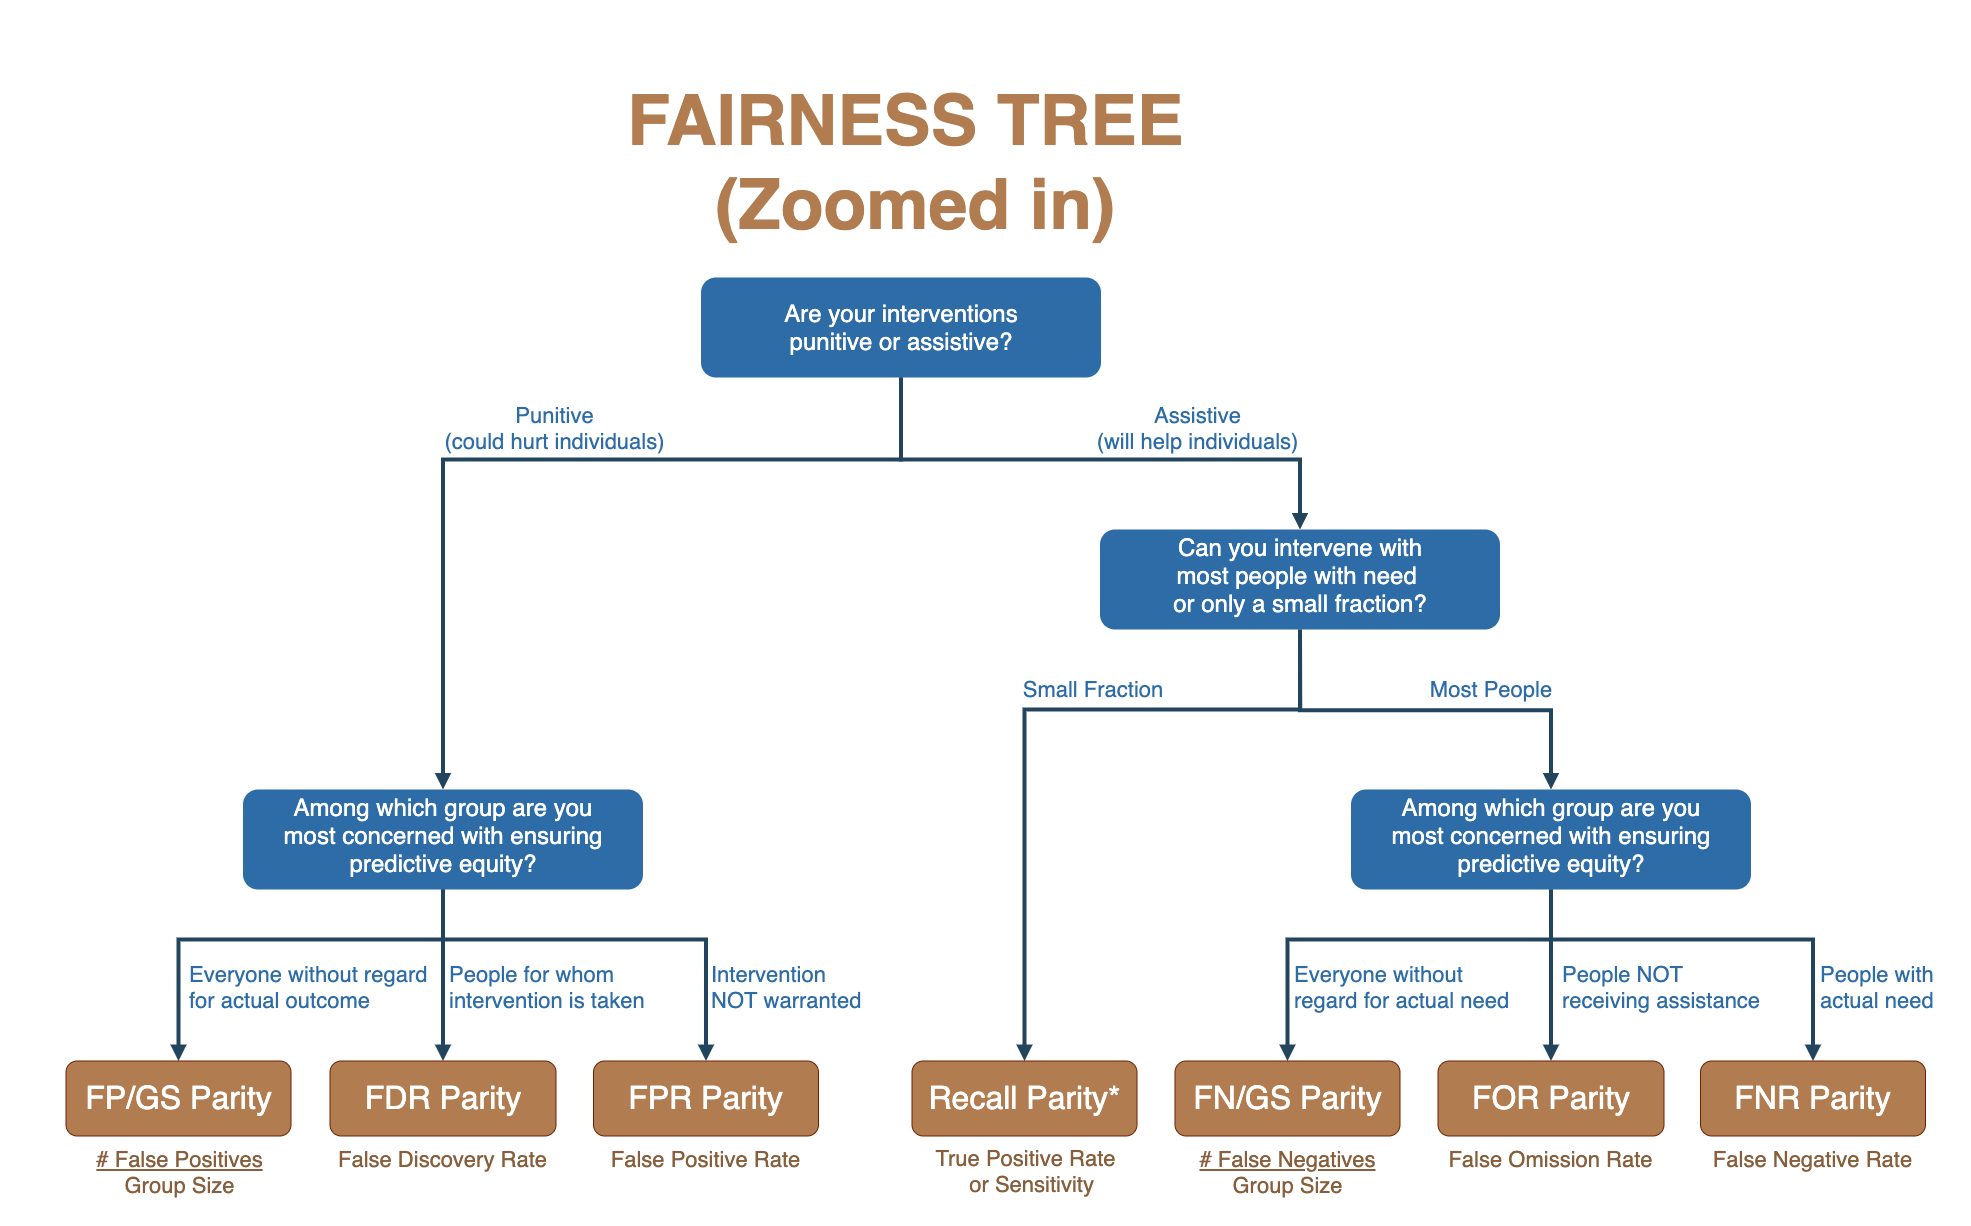

<a id='heading--3-1'></a>
## 3.1 Importing Relevant Libraries

As with any Python program, the first step will be to import the necessary packages. Below we import several components from the Aequitas package. We also import some other non-Aequitas useful packages.

In [27]:
#!pip install aequitas
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot
import aequitas.plot as ap
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

<a id='heading--3-2'></a>
## 3.2 Loading and Reformating Datase to fit Aequitas framework 

In [28]:
aequitas_df=X_test.copy()
aequitas_df['score']=y_test_predict
aequitas_df['label_value']=y_test
#aequitas_df.rename(columns={}, inplace=True)
aequitas_df.head()
X_test.head()

Num_Children  Group  Income  Own_Car  Own_Housing
194257             1      1   92093        1            1
396319             2      0   81071        1            0
138738             4      0   83536        0            0
66570              0      0   60953        0            0
149424             1      0   60496        0            0

In [29]:
aequitas_df['Num_Children'] = aequitas_df['Num_Children'].map({0:'None', 1:'1 to 3' , 2:'1 to 3', 3:'1 to 3', 4:'4 to 7', 5:'4 to 7', 6:'4 to 7', 7:'4 to 7', 8:'8 or more'}) 
aequitas_df['Own_Car'] = aequitas_df['Own_Car'].map({0:'No', 1:'Yes'}) 
aequitas_df['Own_Housing'] = aequitas_df['Own_Housing'].map({0:'No', 1:'Yes'}) 
aequitas_df['Group'] = aequitas_df['Group'].map({0:'hispanic', 1:'non_hispanic'}) 
aequitas_df.head()

Num_Children         Group  Income Own_Car Own_Housing  score  \
194257       1 to 3  non_hispanic   92093     Yes         Yes      1   
396319       1 to 3      hispanic   81071     Yes          No      0   
138738       4 to 7      hispanic   83536      No          No      0   
66570          None      hispanic   60953      No          No      0   
149424       1 to 3      hispanic   60496      No          No      0   

        label_value  
194257            1  
396319            0  
138738            0  
66570             0  
149424            0

In [30]:
from sklearn.preprocessing import FunctionTransformer

bins=[0, 75000, 85000, 350000]
labels=['low', 'medium', 'high']

transformer = FunctionTransformer(
    pd.cut, kw_args={'bins': bins, 'labels': labels, 'retbins': False})

aequitas_df['Income'] = transformer.fit_transform(aequitas_df['Income'])
aequitas_df.head()

Num_Children         Group  Income Own_Car Own_Housing  score  \
194257       1 to 3  non_hispanic    high     Yes         Yes      1   
396319       1 to 3      hispanic  medium     Yes          No      0   
138738       4 to 7      hispanic  medium      No          No      0   
66570          None      hispanic     low      No          No      0   
149424       1 to 3      hispanic     low      No          No      0   

        label_value  
194257            1  
396319            0  
138738            0  
66570             0  
149424            0

In [31]:
aequitas_df=aequitas_df[['score', 'label_value', 'Num_Children', 'Group', 'Income', 'Own_Car', 'Own_Housing']]
aequitas_df.head()

score  label_value Num_Children         Group  Income Own_Car  \
194257      1            1       1 to 3  non_hispanic    high     Yes   
396319      0            0       1 to 3      hispanic  medium     Yes   
138738      0            0       4 to 7      hispanic  medium      No   
66570       0            0         None      hispanic     low      No   
149424      0            0       1 to 3      hispanic     low      No   

       Own_Housing  
194257         Yes  
396319          No  
138738          No  
66570           No  
149424          No

In [32]:
aequitas_df['Income']=aequitas_df['Income'].astype('object')

<a id='heading--3-3'></a>
## 3.3. Model Biases

Aequitas’s Group() class enables researchers to evaluate biases across all subgroups in their dataset by assembling a confusion matrix of each subgroup, calculating commonly used metrics such as false positive rate and false omission rate, as well as counts by group and group prevelance among the sample population.

In [33]:
g = Group()
xtab, _ = g.get_crosstabs(aequitas_df)

In [34]:
absolute_metrics = g.list_absolute_metrics(xtab)

In [35]:
# View calculated counts across sample population groups
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

model_id score_threshold      k attribute_name attribute_value     pp  \
0          0      binary 0/1  38625   Num_Children          1 to 3  28121   
1          0      binary 0/1  38625   Num_Children          4 to 7   5310   
2          0      binary 0/1  38625   Num_Children       8 or more     33   
3          0      binary 0/1  38625   Num_Children            None   5151   
4          0      binary 0/1  38625          Group        hispanic   9772   
5          0      binary 0/1  38625          Group    non_hispanic  28853   
6          0      binary 0/1  38625         Income            high  31050   
7          0      binary 0/1  38625         Income             low   1355   
8          0      binary 0/1  38625         Income          medium   6220   
9          0      binary 0/1  38625        Own_Car              No   8601   
10         0      binary 0/1  38625        Own_Car             Yes  30024   
11         0      binary 0/1  38625    Own_Housing              No  19123   
12         0      binary 0/1  38625    Own_Housing             Yes  19502   

       pn    fp   fn     tn     tp  group_label_pos  group_label_neg  \
0   44358  1010  982  43376  27111            28093            44386   
1    8718   176  200   8518   5134             5334             8694   
2      52     1    0     52     32               32               53   
3    8235   187  181   8054   4964             5145             8241   
4   40198   735  710  39488   9037             9747            40223   
5   21177   639  653  20524  28214            28867            21163   
6    1516   575  400   1116  30475            30875             1691   
7   52617   275  380  52237   1080             1460            52512   
8    7242   524  583   6659   5696             6279             7183   
9   21309   367  492  20817   8234             8726            21184   
10  40066  1007  871  39195  29017            29888            40202   
11  40589   911  809  39780  18212            19021            40691   
12  20786   463  554  20232  19039            19593            20695   

    group_size  total_entities  
0        72479          100000  
1        14028          100000  
2           85          100000  
3        13386          100000  
4        49970          100000  
5        50030          100000  
6        32566          100000  
7        53972          100000  
8        13462          100000  
9        29910          100000  
10       70090          100000  
11       59712          100000  
12       40288          100000

In [36]:
#View calculated absolute metrics for each sample population group
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

attribute_name attribute_value   tpr   tnr   for   fdr   fpr   fnr   npv  \
0    Num_Children          1 to 3  0.97  0.98  0.02  0.04  0.02  0.03  0.98   
1    Num_Children          4 to 7  0.96  0.98  0.02  0.03  0.02  0.04  0.98   
2    Num_Children       8 or more  1.00  0.98  0.00  0.03  0.02  0.00  1.00   
3    Num_Children            None  0.96  0.98  0.02  0.04  0.02  0.04  0.98   
4           Group        hispanic  0.93  0.98  0.02  0.08  0.02  0.07  0.98   
5           Group    non_hispanic  0.98  0.97  0.03  0.02  0.03  0.02  0.97   
6          Income            high  0.99  0.66  0.26  0.02  0.34  0.01  0.74   
7          Income             low  0.74  0.99  0.01  0.20  0.01  0.26  0.99   
8          Income          medium  0.91  0.93  0.08  0.08  0.07  0.09  0.92   
9         Own_Car              No  0.94  0.98  0.02  0.04  0.02  0.06  0.98   
10        Own_Car             Yes  0.97  0.97  0.02  0.03  0.03  0.03  0.98   
11    Own_Housing              No  0.96  0.98  0.02  0.05  0.02  0.04  0.98   
12    Own_Housing             Yes  0.97  0.98  0.03  0.02  0.02  0.03  0.97   

    precision   ppr  pprev  prev  
0        0.96  0.73   0.39  0.39  
1        0.97  0.14   0.38  0.38  
2        0.97  0.00   0.39  0.38  
3        0.96  0.13   0.38  0.38  
4        0.92  0.25   0.20  0.20  
5        0.98  0.75   0.58  0.58  
6        0.98  0.80   0.95  0.95  
7        0.80  0.04   0.03  0.03  
8        0.92  0.16   0.46  0.47  
9        0.96  0.22   0.29  0.29  
10       0.97  0.78   0.43  0.43  
11       0.95  0.50   0.32  0.32  
12       0.98  0.50   0.48  0.49

***False Positive Rate (FPR)*** is the fraction of individuals whose credit card was denied and the model misclassifies with a approved prediction. FPR is quite low accross all groups and labels. However we observed the medium income group having a relatively bigger FPR rate compared to other groups.

***False Negative Rate (FNR)*** is the fraction of individuals with approved credit cards and the model misclassifies with a denied prediction. 2 groups raise our concerns here: low income group and the hispanic group as FNR rate are significantly higher than for the rest of groups withing their category.

***False Discovery Rate (FDR)*** is the fraction of individuals who the model predicts to have an approved credit card but for whom the card was denied. Hispanic and and low income groups are again the concern here.

***False Omission Rate (FOR)*** is the fraction of individuals who the model predicts to have a denied credit card but for whom the card was actually approved. Medium income group seems to get a benefit from the model

**Precision** is the fraction of individuals who the model predicts to have an approved credit card about whom this prediction is correct. Quite high for all groups except for low income and hispanic group.

***Visualizing default absolute group metrics across all population groups***

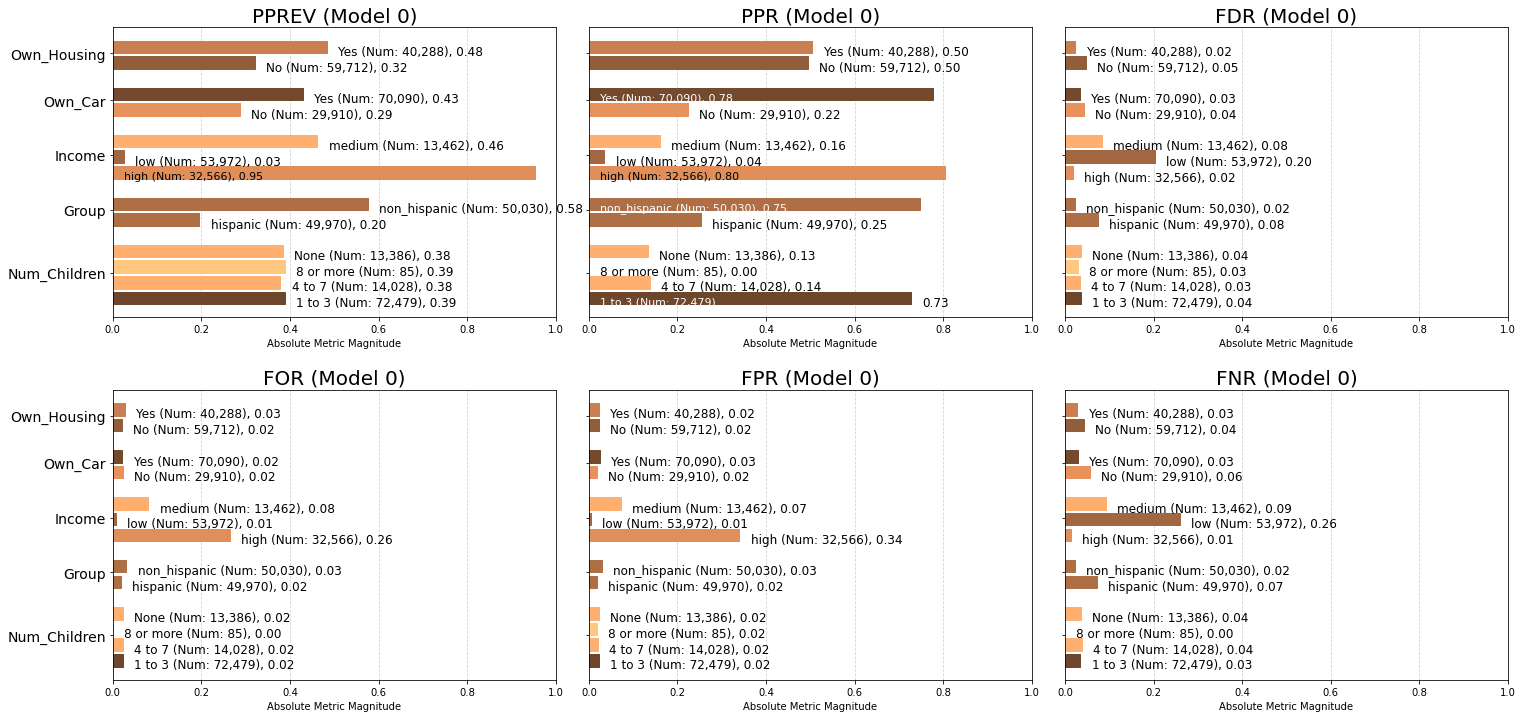

<Figure size 432x288 with 0 Axes>

In [37]:
aqp = Plot()
a = aqp.plot_group_metric_all(xtab, ncols=3)

<a id='heading--3-4'></a>

## 3.4 Model Disparities 



We use the Aequitas Bias() class to calculate disparities between groups based on the crosstab returned by the Group() class ``get_crosstabs()`` method described above. 

Disparities are calculated as a ratio of a metric for a group of interest compared to a base group.

What we have learned from the analysis below is that jispanic and low income group are the groups more affected, hence we are gping to focus our analysis on those two categories

In [38]:
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, original_df=aequitas_df, 
            ref_groups_dict={'Num_Children':"1 to 3", 'Group':"non_hispanic", 'Income':"low", 'Own_Car':"Yes", 'Own_Housing':"No"},
            alpha=0.05, check_significance=True)

get_disparity_predefined_group()


In [39]:
calculated_disparities = b.list_disparities(bdf)
disparity_significance = b.list_significance(bdf)

In [40]:
disparity_significance

['label_value_significance',
 'score_significance',
 'fdr_significance',
 'fnr_significance',
 'for_significance',
 'fpr_significance',
 'npv_significance',
 'ppr_significance',
 'pprev_significance',
 'precision_significance',
 'tnr_significance',
 'tpr_significance']

In [41]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +  calculated_disparities + disparity_significance]

attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0    Num_Children          1 to 3       1.000000       1.000000   
1    Num_Children          4 to 7       0.922842       1.072664   
2    Num_Children       8 or more       0.843714       0.000000   
3    Num_Children            None       1.010787       1.006421   
4           Group        hispanic       3.396206       3.220148   
5           Group    non_hispanic       1.000000       1.000000   
6          Income            high       0.091246       0.049776   
7          Income             low       1.000000       1.000000   
8          Income          medium       0.415095       0.356736   
9         Own_Car              No       1.272202       1.934767   
10        Own_Car             Yes       1.000000       1.000000   
11    Own_Housing              No       1.000000       1.000000   
12    Own_Housing             Yes       0.498356       0.664804   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0        1.000000       1.000000       1.000000       1.000000   
1        1.036272       0.889647       0.999179       0.188827   
2        0.000000       0.829180       1.022639       0.001174   
3        0.992831       0.997209       1.000162       0.183173   
4        0.572803       0.605187       1.013592       0.338682   
5        1.000000       1.000000       1.000000       1.000000   
6       36.534509      64.930703       0.741503      22.915129   
7        1.000000       1.000000       1.000000       1.000000   
8       11.146859      13.930005       0.926186       4.590406   
9        1.062086       0.691634       0.998620       0.286471   
10       1.000000       1.000000       1.000000       1.000000   
11       1.000000       1.000000       1.000000       1.000000   
12       1.337207       0.999299       0.993142       1.019819   

    pprev_disparity  precision_disparity  ...  fdr_significance  \
0          1.000000             1.000000  ...             False   
1          0.975619             1.002874  ...             False   
2          1.000637             1.005822  ...             False   
3          0.991796             0.999598  ...             False   
4          0.339089             0.945730  ...              True   
5          1.000000             1.000000  ...             False   
6         37.977503             1.231396  ...              True   
7          1.000000             1.000000  ...             False   
8         18.403906             1.148934  ...              True   
9          0.671305             0.990554  ...             False   
10         1.000000             1.000000  ...              True   
11         1.000000             1.000000  ...             False   
12         1.511503             1.025093  ...              True   

    fnr_significance  for_significance  fpr_significance  npv_significance  \
0              False             False             False             False   
1              False             False             False             False   
2              False             False             False             False   
3              False             False             False             False   
4               True              True              True              True   
5              False             False             False             False   
6               True              True              True              True   
7              False             False             False             False   
8               True              True              True              True   
9              False             False             False             False   
10              True              True              True              True   
11             False             False             False             False   
12              True              True              True              True   

    ppr_significance  pprev_significance  precision_significance  \
0              False               Fals

In the table above we see the disparities of each class, compared to the reference class. The reference class of each attribute has disparities of 1 (compared to itself).
We can verify that for "hispanic" in the sensitive class (Group), the differences in False Discovery Rate (FDR) and False Negative Rate (FNR) are both above 3 times the one of the reference class (non-hispanic). 
Another aspect that can be highlighted is the 1.5 Predicted Prevalence disparity of Owner of housing.

Scrolling to the right in the table, the significance for a 5% of each of the metrics disparities is displayed. 
If we check FDR and FNR for hispanic we see that those disparities are marked as significant (TRUE).

In a nutshell, the tool detects significant disparities in:
- hispanic
- medium and high income
- owning a house
- owning a car

In the graphs below, Aequitas helps in the visualization of the dispairites discoverd by category.  

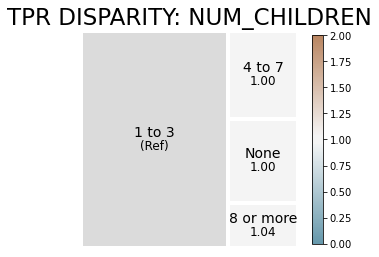

In [42]:
ppr_disparity = aqp.plot_disparity(bdf, group_metric='tpr_disparity',
attribute_name='Num_Children')

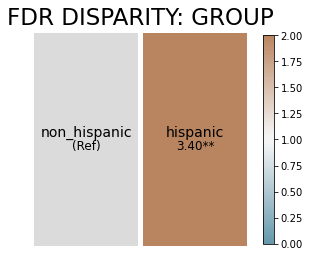

In [43]:
fdr_disparity = aqp.plot_disparity(bdf, group_metric='fdr_disparity',
attribute_name='Group')

<a id='heading--3-5'></a>
## 3.5 Overall Fairness

In [44]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

The chart below summarizes the fairness of the model through the Predicted Positive Rate Disparity (PPR) for all the attributes. The green colour indicates True and red False.

The interpretation is that the prediction is fair for hispanics with 1 to 3 children, owning a car and owning or not a house though for the rest of the categories the model would not be fair according to the PPR disparity. 

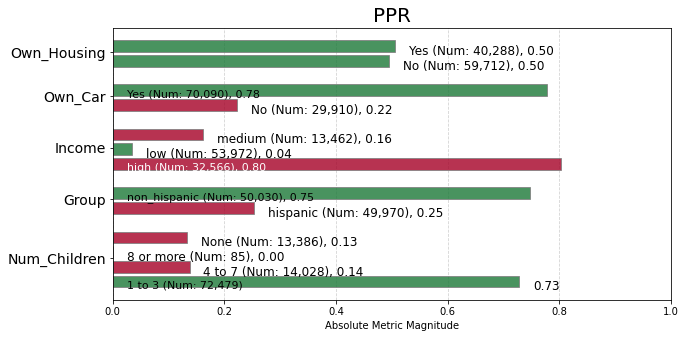

In [45]:
ppr_fairness = aqp.plot_fairness_group(fdf, group_metric='ppr', title=True)

The model includes the possibility to extend this analysis to an important amount of metrics.  

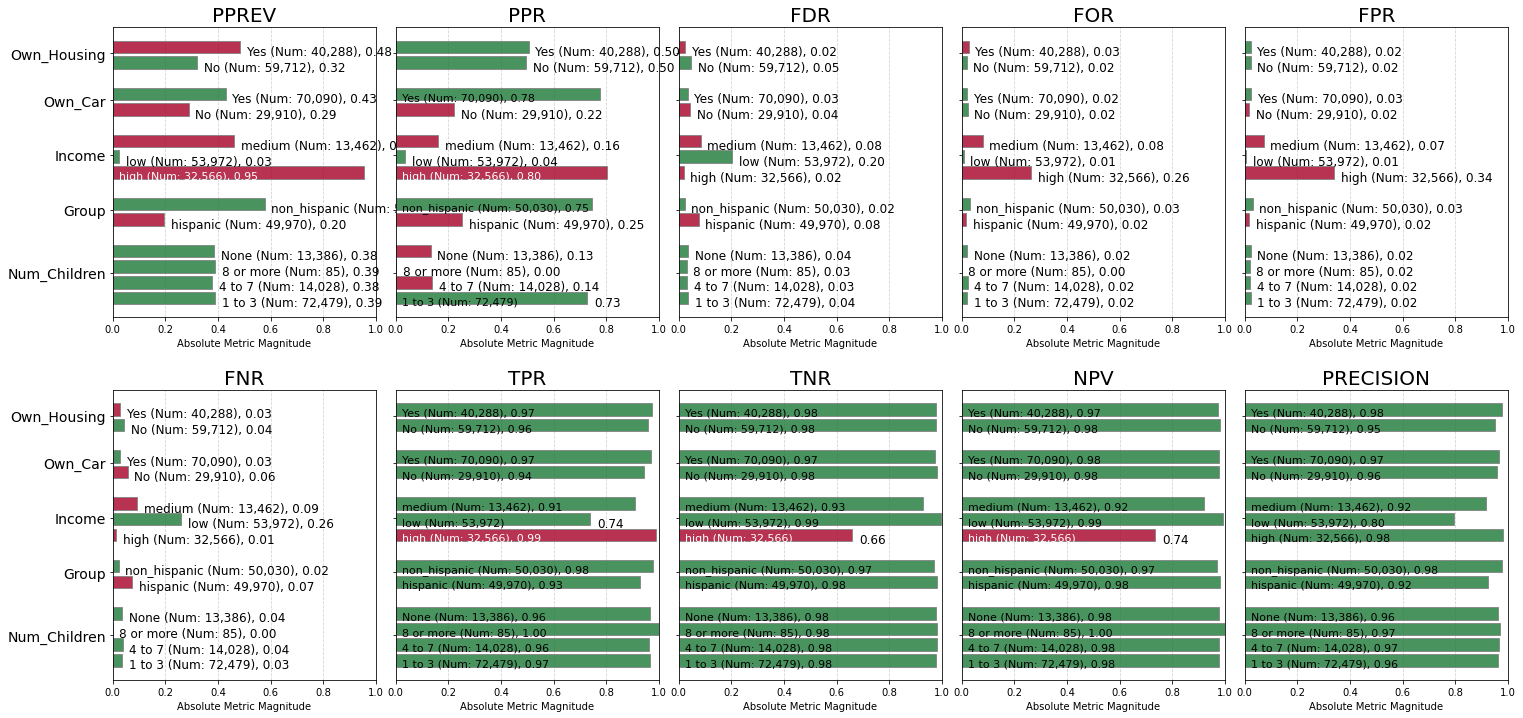

<Figure size 432x288 with 0 Axes>

In [46]:
fg = aqp.plot_fairness_group_all(fdf, ncols=5, metrics = "all")

<a id='heading--3-6'></a>
## 3.6 The Parity Test

The Parity Test graphs is another visualization aid that help us dentify where the bias is based on a defined disparty tolerance tha can be adjusted according to the results a research desires to evaluate. 
Fot the sake of this exercise we have selected a disparity tolerance of 1.5

As per the results we can observed for each one of the categories in the Synthetic Credit Card, what is the level of disparity compared to the reference gorup for each one of the variables
For instance 

Aequitas has a more compact summary visualization for the parity test of the attributes and metrics we chose:   

In [47]:
metrics = ['fpr', 'fdr', 'precision', 'ppr','tpr', 'tnr' ]
disparity_tolerance = 1.25

In [48]:
ap.summary(bdf, metrics, fairness_threshold = disparity_tolerance)

alt.VConcatChart(...)

In [49]:
ap.disparity(bdf, metrics, 'Num_Children', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

In [50]:
ap.disparity(bdf, metrics, 'Income', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

In [51]:
ap.disparity(bdf, metrics, 'Own_Car', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

In [52]:
ap.disparity(bdf, metrics, 'Own_Housing', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

In [53]:
ap.disparity(bdf, metrics, 'Group', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)